In [2]:
%reload_ext autoreload

%autoreload 2

import math
import os

import iris
import iris.analysis.cartography
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.helpers import plot_over_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree, plot_grid

In [83]:
split = "val"
dataset_name = "2.2km-coarsened-8x_london_vorticity850_random"
eval_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", dataset_name, f"{split}.nc"))
eval_ds["target_pr"] = eval_ds["target_pr"]*3600*24
eval_ds

<xarray.Dataset>
Dimensions:                     (time: 4320, bnds: 2, grid_latitude: 64,
                                 grid_longitude: 64)
Coordinates:
  * time                        (time) object 1980-12-03 12:00:00 ... 2080-11...
  * grid_latitude               (grid_latitude) float32 -1.58 -1.56 ... -0.32
  * grid_longitude              (grid_longitude) float32 360.9 360.9 ... 362.1
    forecast_period             (time) timedelta64[ns] ...
    forecast_reference_time     (time) object ...
    realization                 int32 ...
    pressure                    float32 ...
    season                      (time) int64 ...
Dimensions without coordinates: bnds
Data variables:
    rotated_latitude_longitude  (time) float64 ...
    time_bnds                   (time, bnds) object ...
    grid_latitude_bnds          (time, grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (time, grid_longitude, bnds) float32 ...
    forecast_period_bnds        (time, bnds) float64 ...
    target_pr                   (time, grid_latitude, grid_longitude) float32 ...
    vorticity850                (time, grid_latitude, grid_longitude) float64 ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.6
    Conventions:  CF-1.7

In [86]:
sorted_time = eval_ds.sum(dim=['grid_latitude', 'grid_longitude']).sortby('target_pr')["time"].values
sorted_time

array([cftime.Datetime360Day(2025, 9, 5, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2078, 6, 9, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2038, 4, 26, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.Datetime360Day(2062, 11, 26, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2063, 1, 19, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2033, 11, 19, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [80]:
import metpy.plots.ctables

def show_predictions(da, timestamps, cmap, norm):
    fig, axes = plt.subplots(1, len(timestamps), figsize=(6*len(timestamps),6), constrained_layout=True, subplot_kw={'projection': cp_model_rotated_pole})
    
    for i, ts in enumerate(timestamps):
        ax = axes[i]
        plot_grid(da.sel(time=ts), ax, title=f"Target pr {ts}", cmap=cmap, norm=norm, add_colorbar=True)

    plt.show()

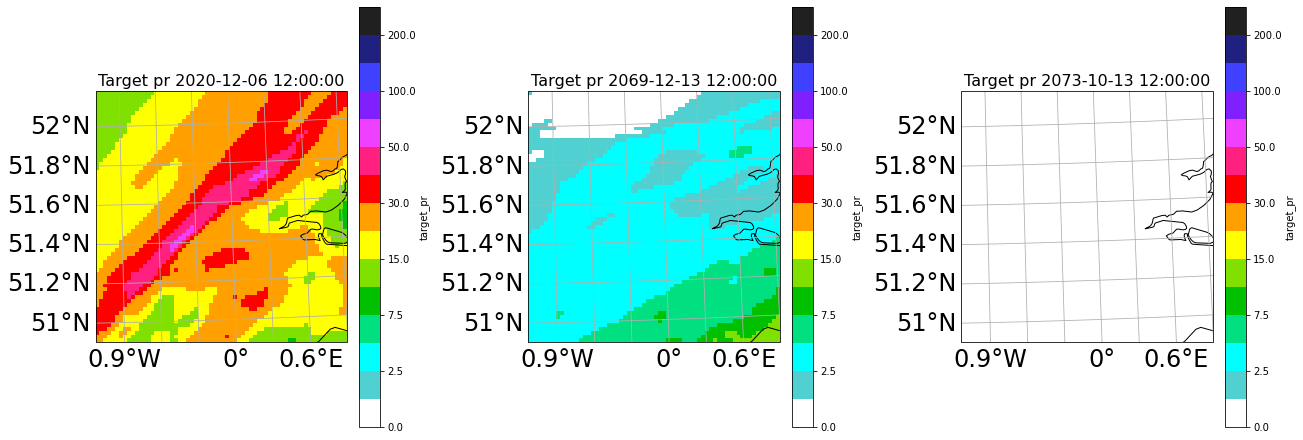

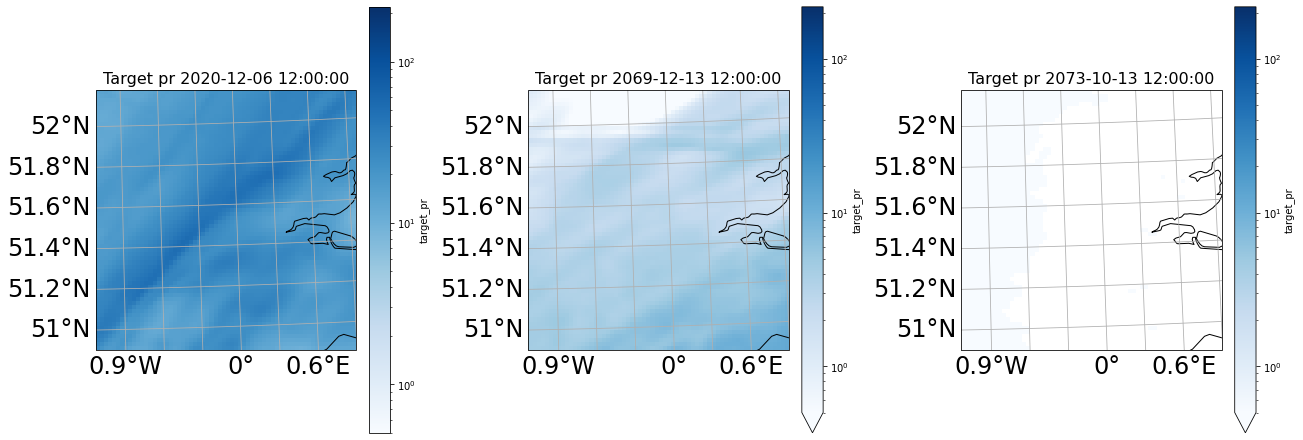

In [81]:
# timestamps = np.concatenate([
#     sorted_time[t:t+3] for t in [
#         -20, 
#         # math.ceil(len(sorted_time)*0.9),
#         math.ceil(len(sorted_time)*0.81),
#         # math.ceil(len(sorted_time)*0.5), 
#         # 17
#     ]
# ])

timestamps = np.array([
    sorted_time[t] for t in [
        -20, 
        # math.ceil(len(sorted_time)*0.9),
        math.ceil(len(sorted_time)*0.81),
        # math.ceil(len(sorted_time)*0.5), 
        17
    ]
])
# timestamps = np.random.choice(sorted_time, size=2*3, replace=False)
vmin = 0.5#1e-1*3600*24
vmax = eval_ds['target_pr'].max().values

da = eval_ds.sel(time=timestamps)["target_pr"]

# draw filled contours.
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750, 1000]

cmap = matplotlib.colors.ListedColormap(metpy.plots.ctables.colortables["precipitation"][:15], 'precipitation')
norm = matplotlib.colors.BoundaryNorm(clevs[:16], cmap.N)


show_predictions(da, timestamps, cmap, norm)

# norm, cmap = metpy.plots.ctables.registry.get_with_boundaries('precipitation', clevs)
# show_predictions(da, cmap, norm)

show_predictions(da, timestamps, "Blues", matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))